In [1]:
# -- Packages
import numpy as np
import pandas as pd 
import os
# -- Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)
    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)
    return data

In [39]:
def define_model(df, name, train_test_ratio=0.9):
    # Tạo các đặc trưng theo chu kỳ ngày tháng
    fourier = CalendarFourier(freq='A', order=9)
    dp = DeterministicProcess(index=df.index.to_period('D'),
                              constant=True,
                              order=1,
                              seasonal=False,
                              additional_terms=[fourier],
                              drop=True)
    # Tạo DataFrame đặc trưng
    X = dp.in_sample()

    # Lấy giá trị mục tiêu
    y = df['Price']

    # Chia dữ liệu thành tập huấn luyện và kiểm tra
    train_size = int(len(X) * train_test_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Huấn luyện mô hình hồi quy tuyến tính
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Đánh giá mô hình
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print(f'Testing RMSE:{test_rmse}')
    print(f'Testing MAE: {mae}')
    print(f'Testing MAPE: {mape}')
    # Tạo các đặc trưng cho ngày tiếp theo
    future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')
    X_future = dp.out_of_sample(steps=90)
    # Dự đoán ngày tiếp theo
    y_future_pred = model.predict(X_future)
    # Hiển thị dự đoán
    future_predictions = pd.DataFrame({'Date': future_dates, 'Predicted_Price': y_future_pred})
    print(future_predictions)
    # Vẽ biểu đồ kết quả
    plt.figure(figsize=(14, 7))
    plt.plot(y_train.index, y_train, label='Train Prices')
    plt.plot(y_test.index, y_test, label='Test Prices')
    plt.plot(X_test.index, y_pred, label='Predicted Prices')
    plt.plot(future_predictions[0:30]['Date'], future_predictions[0:30]['Predicted_Price'], label=f'Next {30} Days', color='orange')
    plt.plot(future_predictions[31:60]['Date'], future_predictions[31:60]['Predicted_Price'], label=f'Next {60} Days', color='red')
    plt.plot(future_predictions[61:90]['Date'], future_predictions[61:90]['Predicted_Price'], label=f'Next {90} Days', color='black')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{name} prediction')
    plt.legend()
    plt.show()

<font size = '24'>BID</font>

In [29]:
# Đọc dữ liệu từ tệp CSV
df = read_file('../Dataset/BID Historical Data.csv')

# Kiểm tra thông tin về dữ liệu
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1598 entries, 2018-01-02 to 2024-05-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1598 non-null   float64
 1   Open      1598 non-null   object 
 2   High      1598 non-null   object 
 3   Low       1598 non-null   object 
 4   Vol.      1598 non-null   object 
 5   Change %  1598 non-null   object 
dtypes: float64(1), object(5)
memory usage: 87.4+ KB


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-01-02,20664.3,"19,516.3","20,664.3","19,286.7",3.65M,5.88%
2018-01-03,20511.2,"20,664.3","20,702.5","20,281.6",3.09M,-0.74%
2018-01-04,21085.2,"20,511.2","21,200.0","20,319.9",5.56M,2.80%
2018-01-05,20970.4,"21,046.9","21,085.2","20,626.0",2.40M,-0.54%
2018-01-08,21314.8,"21,200.0","21,582.7","20,970.4",2.58M,1.64%


BID 9:1

Testing RMSE:5719.048605309813
Testing MAE: 4611.463939631951
Testing MAPE: 0.09404793311484974
         Date  Predicted_Price
0  2024-06-01     40754.291382
1  2024-06-02     40723.335385
2  2024-06-03     40687.204369
3  2024-06-04     40646.643525
4  2024-06-05     40602.446692
..        ...              ...
85 2024-08-25     42209.651120
86 2024-08-26     42238.998638
87 2024-08-27     42266.548104
88 2024-08-28     42292.271043
89 2024-08-29     42316.117184

[90 rows x 2 columns]


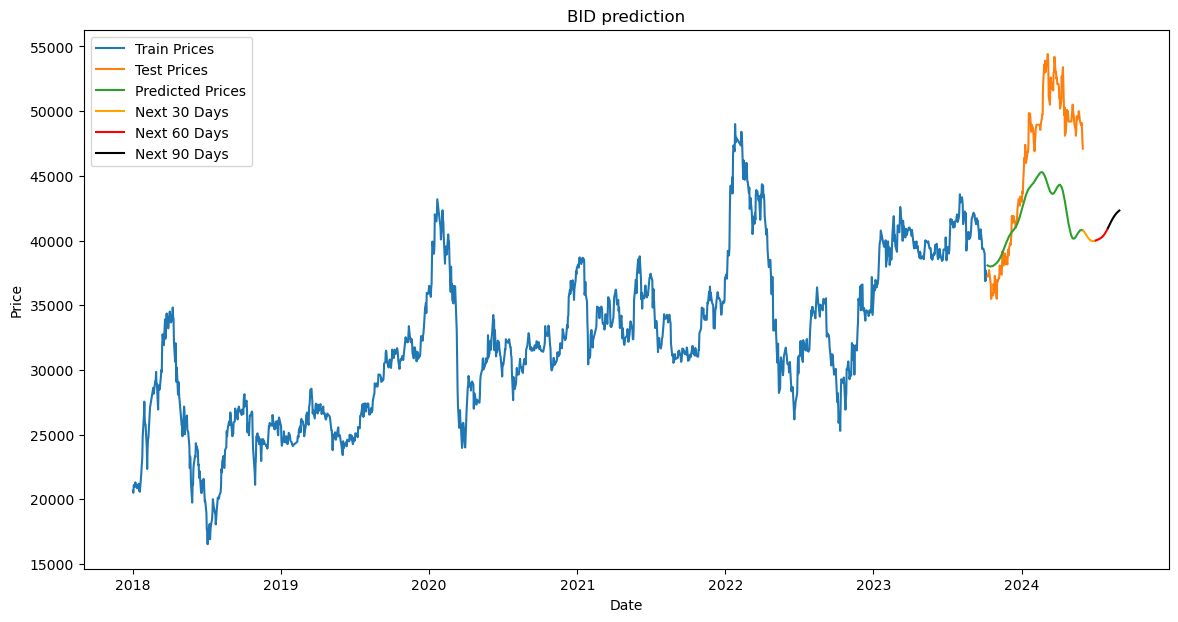

In [40]:
define_model(df,'BID',0.9)

BID 8:2

Testing RMSE:5034.109915289389
Testing MAE: 3829.7098298448423
Testing MAPE: 0.08301532478373404
         Date  Predicted_Price
0  2024-06-01     39614.026067
1  2024-06-02     39581.230414
2  2024-06-03     39541.446068
3  2024-06-04     39495.539188
4  2024-06-05     39444.453765
..        ...              ...
85 2024-08-25     40906.978262
86 2024-08-26     40937.143474
87 2024-08-27     40963.053760
88 2024-08-28     40984.929866
89 2024-08-29     41003.009315

[90 rows x 2 columns]


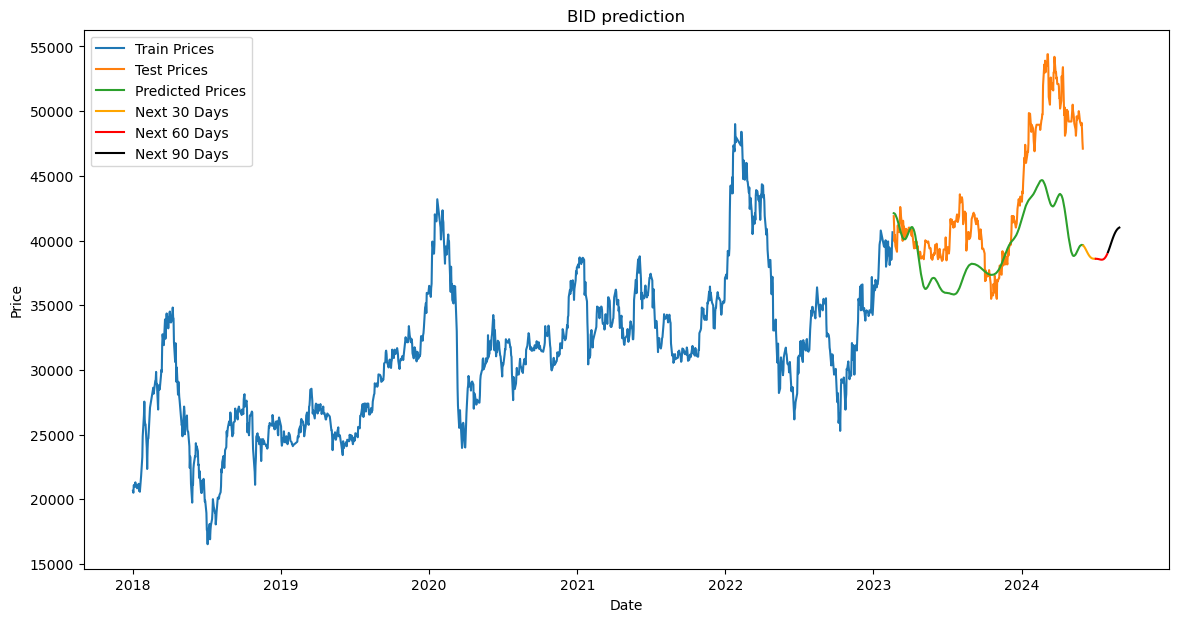

In [41]:
define_model(df,'BID',0.8)

BID 7:3

Testing RMSE:4643.148785310907
Testing MAE: 3800.978360234049
Testing MAPE: 0.101330585821881
         Date  Predicted_Price
0  2024-06-01     42228.733829
1  2024-06-02     42192.570246
2  2024-06-03     42149.224072
3  2024-06-04     42099.715688
4  2024-06-05     42045.170340
..        ...              ...
85 2024-08-25     44082.806898
86 2024-08-26     44133.487446
87 2024-08-27     44179.518380
88 2024-08-28     44221.225648
89 2024-08-29     44259.002493

[90 rows x 2 columns]


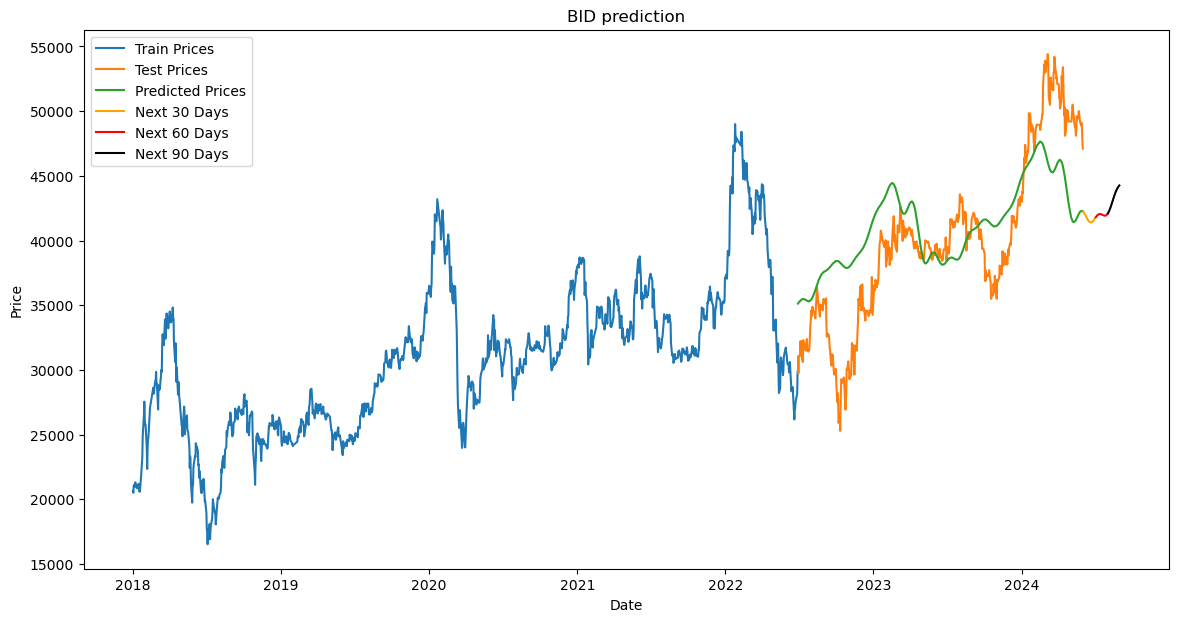

In [42]:
define_model(df,'BID',0.7)

<font size = '24'>MBB</font>

In [43]:
# Đọc dữ liệu từ tệp CSV
df = read_file('../Dataset/MBB Historical Data.csv')

# Kiểm tra thông tin về dữ liệu
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1598 entries, 2018-01-02 to 2024-05-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1598 non-null   float64
 1   Open      1598 non-null   object 
 2   High      1598 non-null   object 
 3   Low       1598 non-null   object 
 4   Vol.      1598 non-null   object 
 5   Change %  1598 non-null   object 
dtypes: float64(1), object(5)
memory usage: 87.4+ KB


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-01-02,10696.2,"10,273.2","10,696.2","10,212.7",19.00M,4.53%
2018-01-03,10595.5,"10,716.3","10,817.0","10,555.2",18.30M,-0.94%
2018-01-04,10615.6,"10,655.9","10,696.2","10,535.0",15.69M,0.19%
2018-01-05,10535.0,"10,635.7","10,655.9","10,454.5",23.65M,-0.76%
2018-01-08,11058.8,"10,514.9","11,058.8","10,494.7",22.19M,4.97%


MBB 9:1

Testing RMSE:1851.3967383363401
Testing MAE: 1628.4389638434084
Testing MAPE: 0.08376167936006783
         Date  Predicted_Price
0  2024-06-01     21704.615972
1  2024-06-02     21712.775047
2  2024-06-03     21717.965009
3  2024-06-04     21720.650249
4  2024-06-05     21721.315548
..        ...              ...
85 2024-08-25     22368.575590
86 2024-08-26     22357.602651
87 2024-08-27     22347.402327
88 2024-08-28     22338.235633
89 2024-08-29     22330.310856

[90 rows x 2 columns]


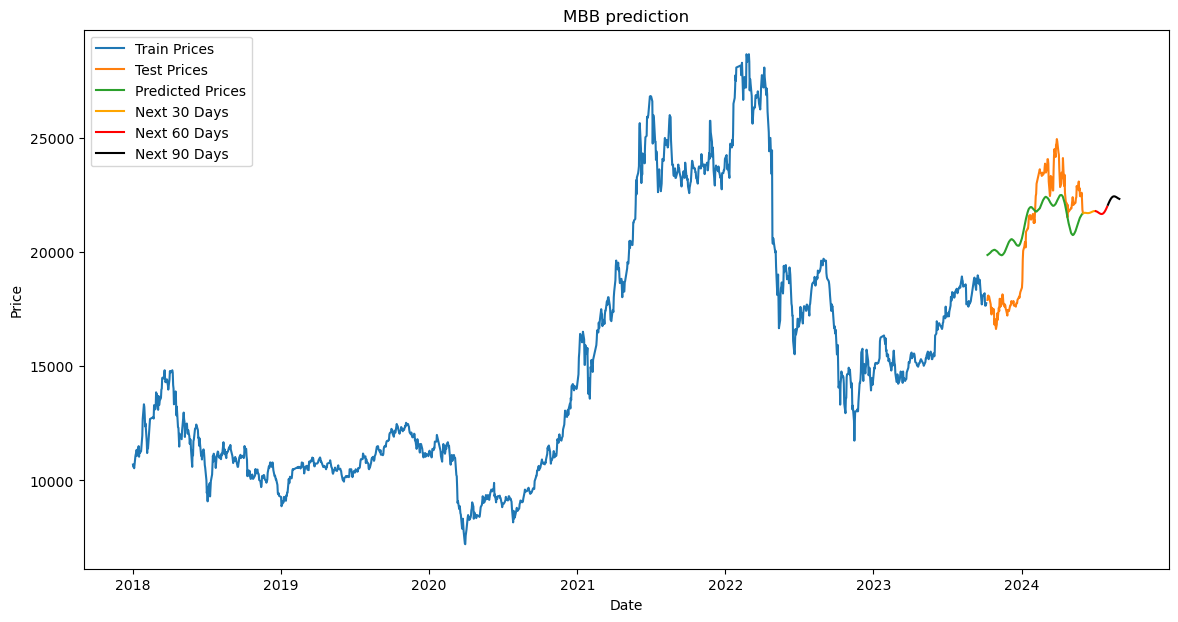

In [44]:
define_model(df,'MBB',0.9)

MBB 8:2


Testing RMSE:4836.991522350191
Testing MAE: 4364.9476113876935
Testing MAPE: 0.25582171287226363
         Date  Predicted_Price
0  2024-06-01     24848.915096
1  2024-06-02     24840.283379
2  2024-06-03     24826.953170
3  2024-06-04     24809.760696
4  2024-06-05     24789.584212
..        ...              ...
85 2024-08-25     25203.126625
86 2024-08-26     25179.860353
87 2024-08-27     25157.081634
88 2024-08-28     25135.370789
89 2024-08-29     25115.245465

[90 rows x 2 columns]


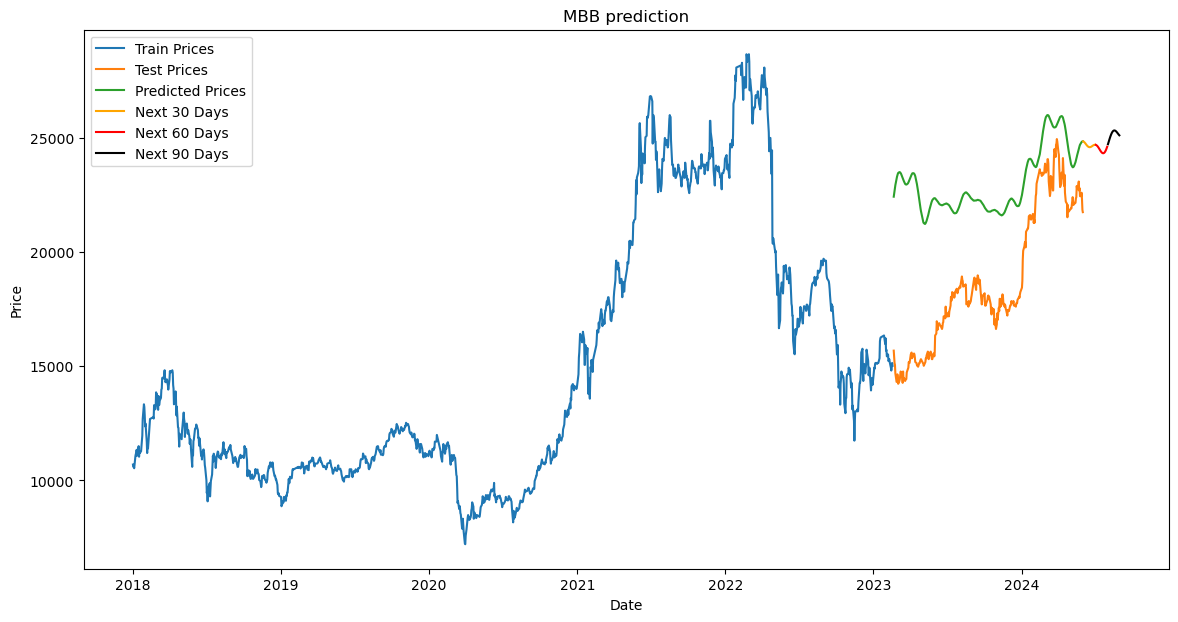

In [45]:
define_model(df,'MBB',0.8)

MBB 7:3

Testing RMSE:7823.866333855408
Testing MAE: 7539.177026997355
Testing MAPE: 0.4475045132170711
         Date  Predicted_Price
0  2024-06-01     28249.031636
1  2024-06-02     28240.808112
2  2024-06-03     28228.845423
3  2024-06-04     28214.019233
4  2024-06-05     28197.253029
..        ...              ...
85 2024-08-25     29447.030610
86 2024-08-26     29423.350257
87 2024-08-27     29398.204982
88 2024-08-28     29372.250636
89 2024-08-29     29346.151691

[90 rows x 2 columns]


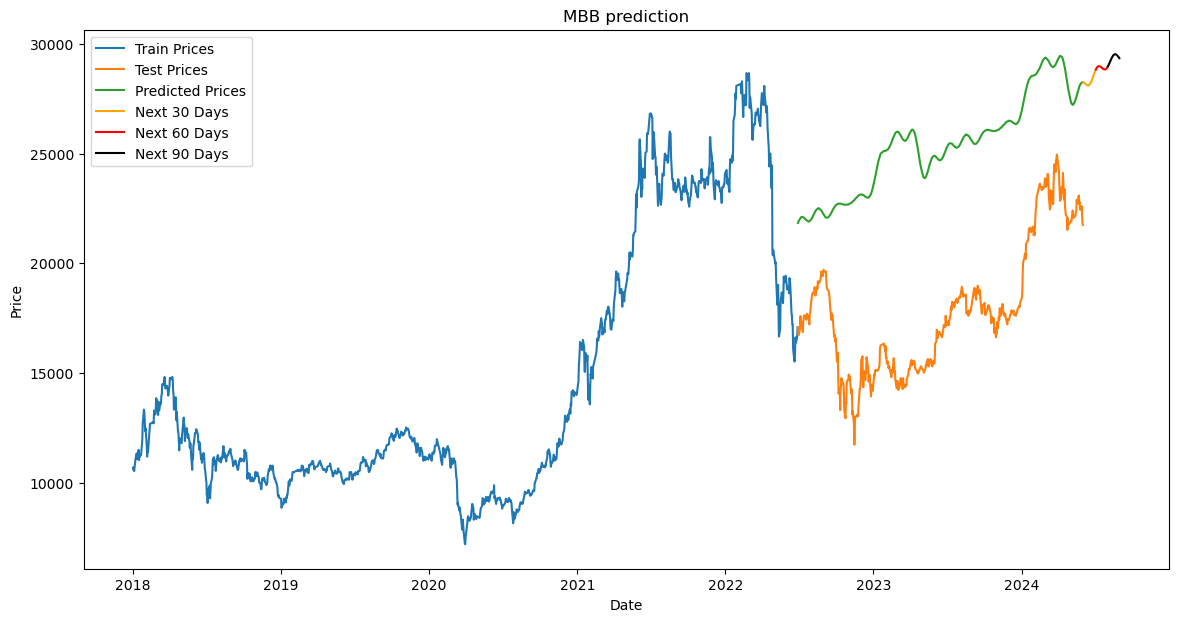

In [46]:
define_model(df,'MBB',0.7)

<font size = '24'>VCB</font>

In [47]:
# Đọc dữ liệu từ tệp CSV
df = read_file('../Dataset/VCB Historical Data.csv')

# Kiểm tra thông tin về dữ liệu
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1598 entries, 2018-01-02 to 2024-05-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1598 non-null   float64
 1   Open      1598 non-null   object 
 2   High      1598 non-null   object 
 3   Low       1598 non-null   object 
 4   Vol.      1598 non-null   object 
 5   Change %  1598 non-null   object 
dtypes: float64(1), object(5)
memory usage: 87.4+ KB


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-01-02,41700.0,"40,942","42,003","40,638",3.57M,1.29%
2018-01-03,41624.0,"42,079","42,230","41,321",2.35M,-0.18%
2018-01-04,42003.0,"41,396","42,003","41,169",2.54M,0.91%
2018-01-05,40942.0,"41,776","41,776","40,866",2.61M,-2.53%
2018-01-08,42003.0,"40,942","42,079","40,183",2.64M,2.59%


VCB 9:1



Testing RMSE:4474.240449346202
Testing MAE: 3779.5852353465802
Testing MAPE: 0.04179376067622766
         Date  Predicted_Price
0  2024-06-01     87700.455874
1  2024-06-02     87855.581368
2  2024-06-03     88010.608424
3  2024-06-04     88165.344141
4  2024-06-05     88319.532095
..        ...              ...
85 2024-08-25     91622.763571
86 2024-08-26     91603.285743
87 2024-08-27     91589.323129
88 2024-08-28     91581.691353
89 2024-08-29     91580.997308

[90 rows x 2 columns]


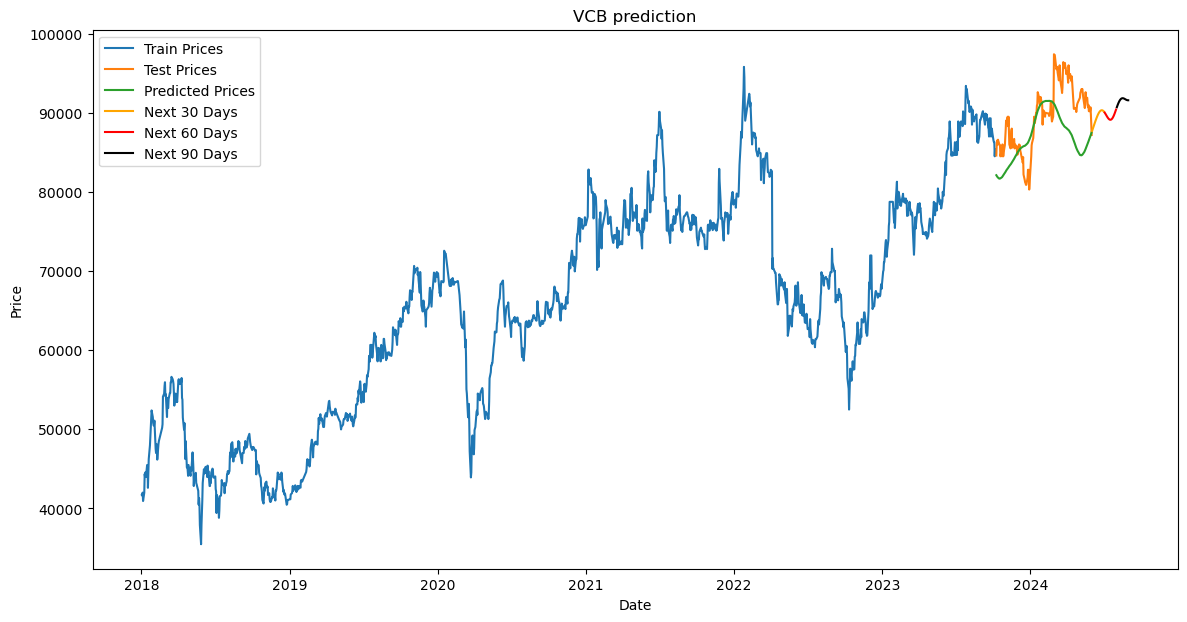

In [48]:
define_model(df,'VCB',0.9)

VCB 8:2

Testing RMSE:5144.085645023053
Testing MAE: 4441.966797893654
Testing MAPE: 0.051334878063648635
         Date  Predicted_Price
0  2024-06-01     87016.108813
1  2024-06-02     87136.574827
2  2024-06-03     87255.795374
3  2024-06-04     87374.080990
4  2024-06-05     87491.698817
..        ...              ...
85 2024-08-25     90361.929584
86 2024-08-26     90329.978363
87 2024-08-27     90299.024926
88 2024-08-28     90270.486664
89 2024-08-29     90245.625718

[90 rows x 2 columns]


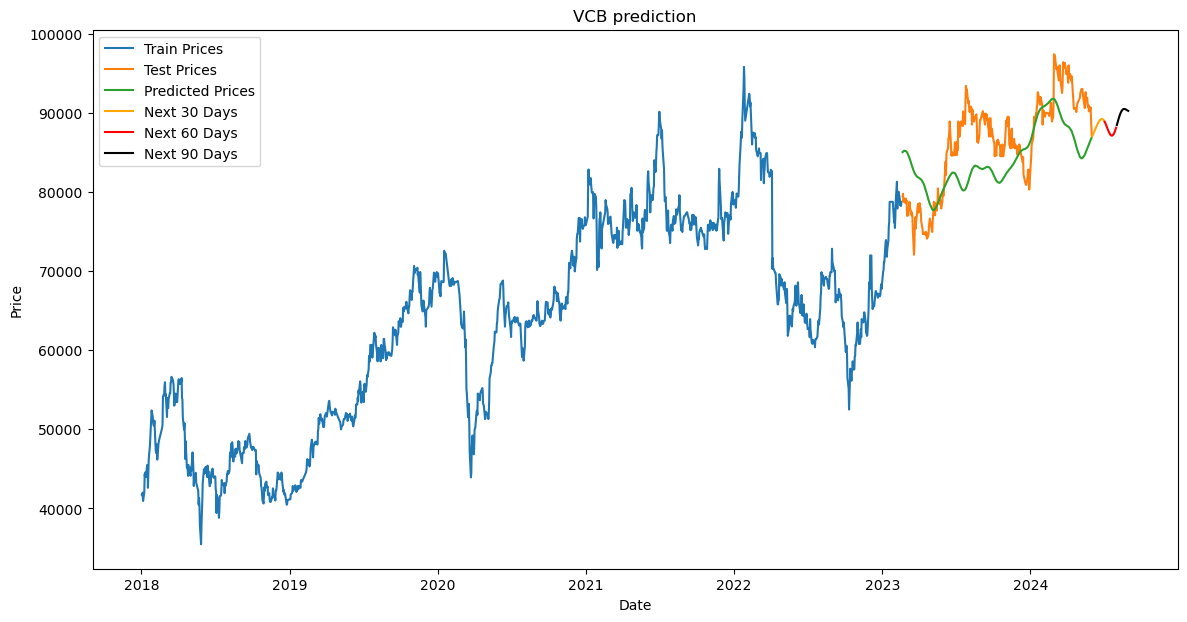

In [49]:
define_model(df,'VCB',0.8)

VCB 7:3

Testing RMSE:13837.124124327815
Testing MAE: 11888.171142736423
Testing MAPE: 0.16518112187213643
         Date  Predicted_Price
0  2024-06-01     96732.255593
1  2024-06-02     96818.487740
2  2024-06-03     96903.415175
3  2024-06-04     96988.473468
4  2024-06-05     97075.149869
..        ...              ...
85 2024-08-25    103622.283805
86 2024-08-26    103604.709276
87 2024-08-27    103582.051043
88 2024-08-28    103555.891641
89 2024-08-29    103527.871156

[90 rows x 2 columns]


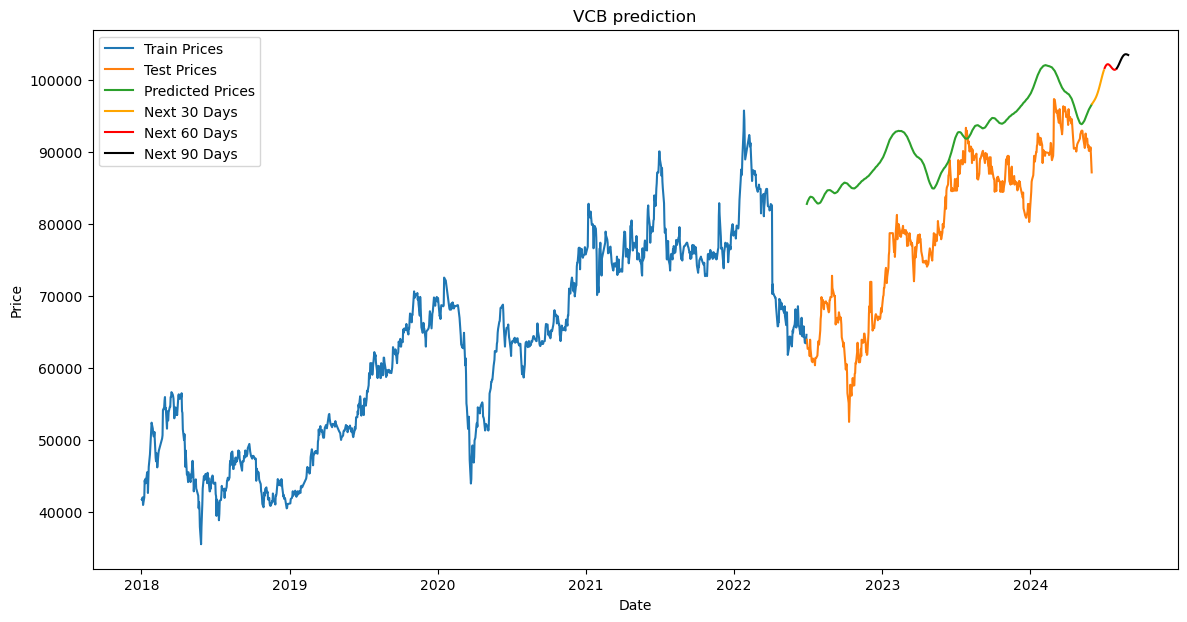

In [50]:
define_model(df,'VCB',0.7)